<a href="https://colab.research.google.com/github/manuelapop/demo_dataset/blob/main/FinalDemodata_setTargetingjobs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using data file: TemplateTargetingJobs_noids.json
Saved cleaned CSV → /content/job_dataset_clean_with_geo_lang_mkt.csv
Categorical cols: 4 | Numeric cols: 72

=== Classification Report (RandomForest) ===

              precision    recall  f1-score   support

       DRAFT       0.99      1.00      1.00       504
   PUBLISHED       0.96      1.00      0.98        90
  PUBLISHING       1.00      0.33      0.50         3
  TRANSLATED       0.00      0.00      0.00         1
    UPDATING       0.00      0.00      0.00         3

    accuracy                           0.99       601
   macro avg       0.59      0.47      0.49       601
weighted avg       0.98      0.99      0.98       601



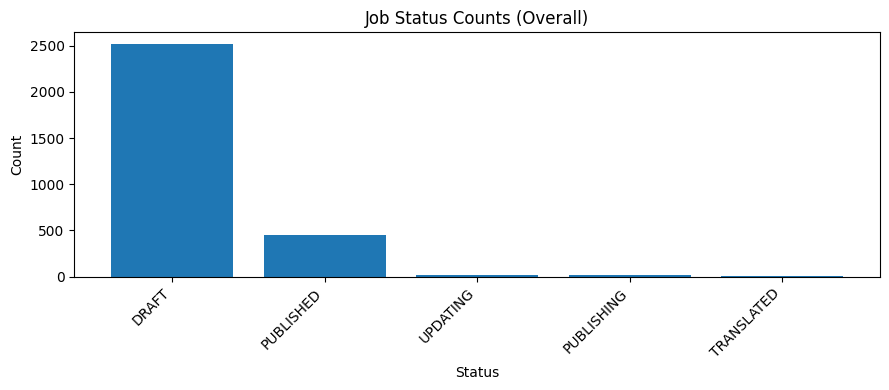

Saved → /content/plot_status_counts.png


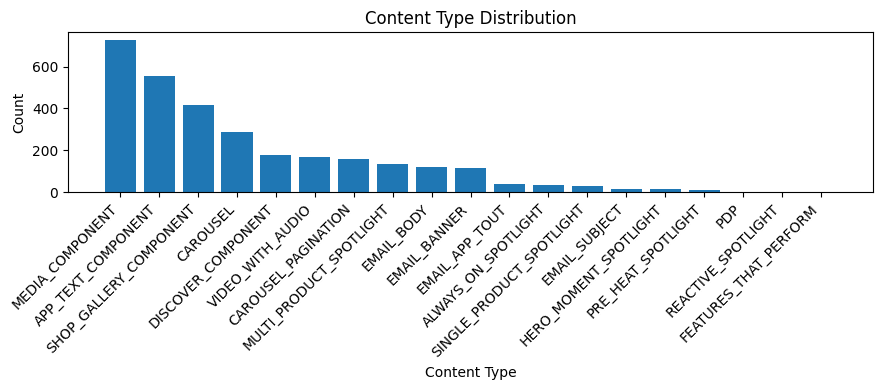

Saved → /content/plot_content_type_distribution.png


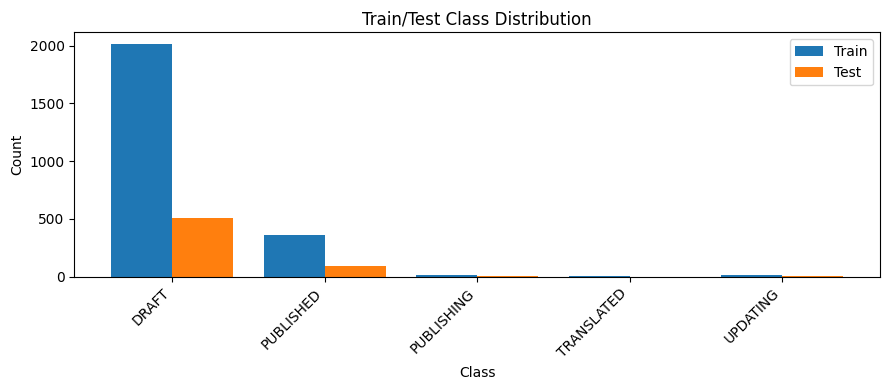

Saved → /content/plot_train_test_balance.png


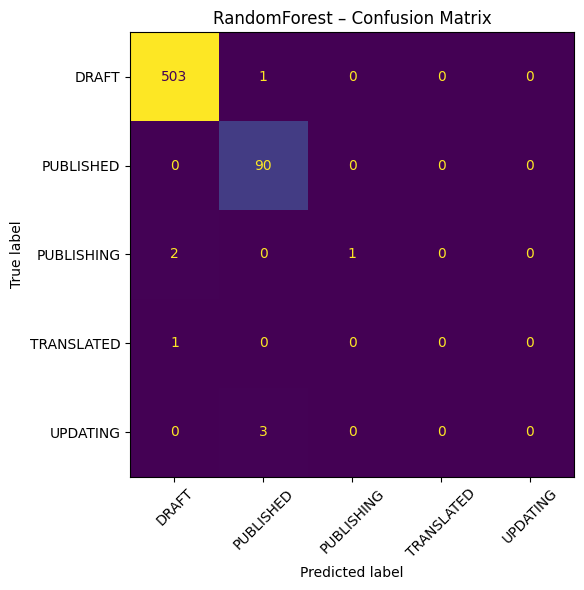

Saved → /content/plot_confusion_matrix.png


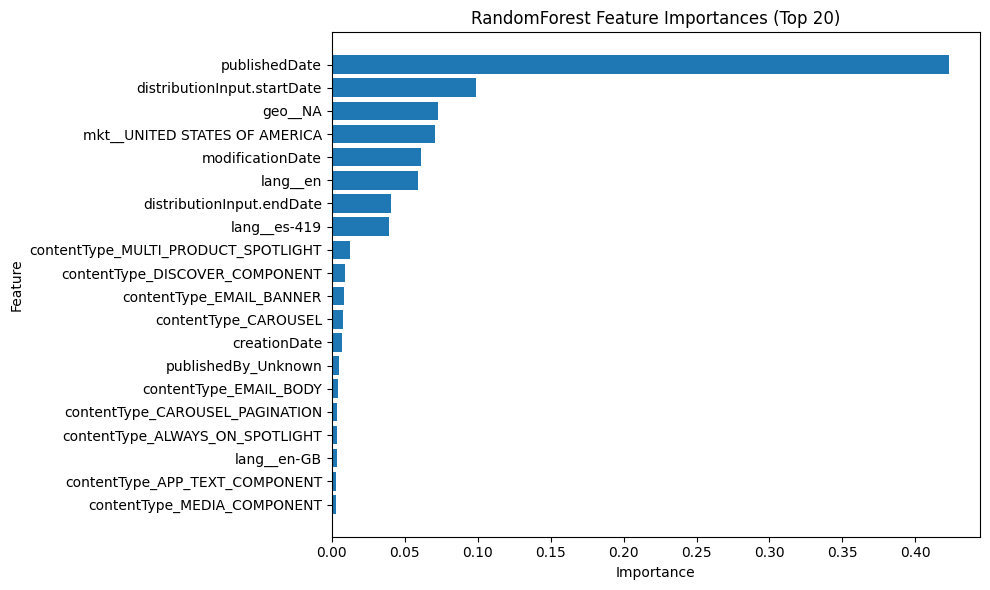

Saved → /content/plot_feature_importances_top20.png


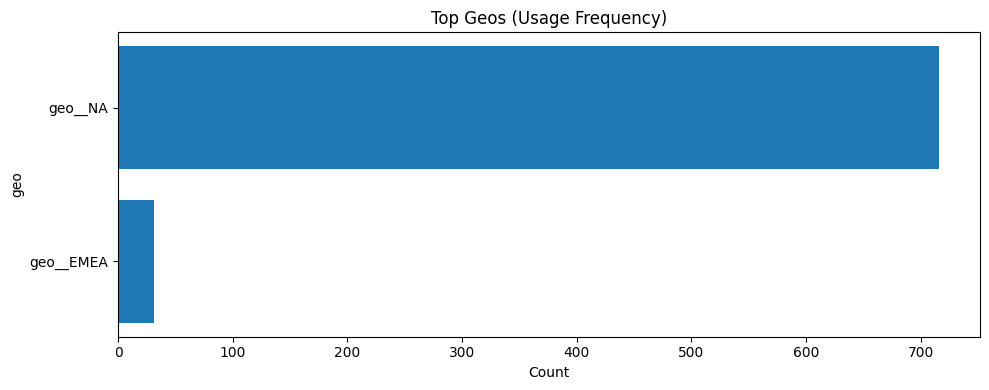

Saved → /content/plot_top_geos.png


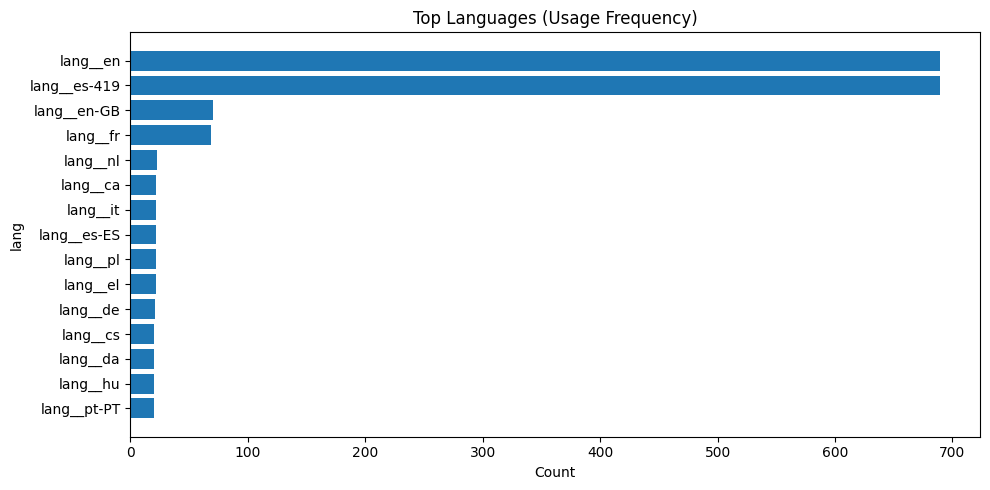

Saved → /content/plot_top_languages.png


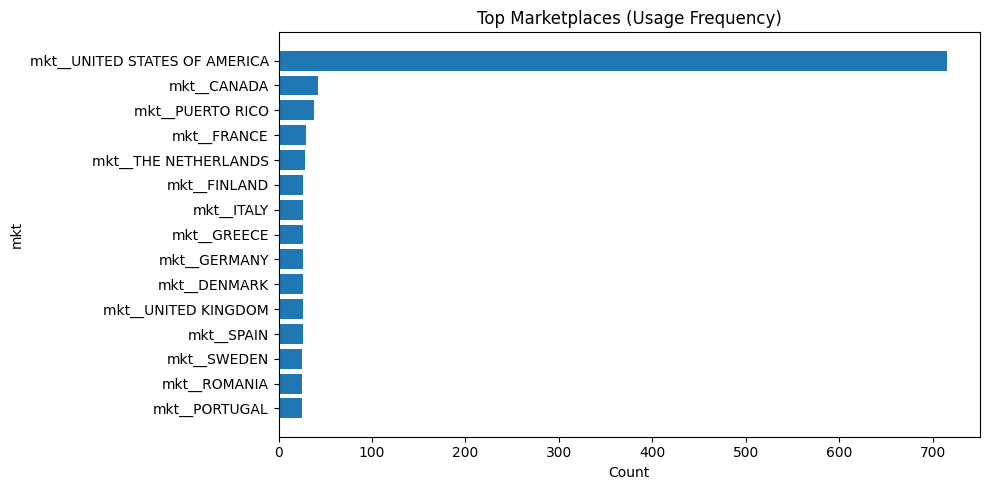

Saved → /content/plot_top_marketplaces.png

Example single-row prediction:
 {'predicted_status': 'PUBLISHED', 'proba': {'DRAFT': 0.1167, 'PUBLISHED': 0.7733, 'PUBLISHING': 0.0, 'TRANSLATED': 0.01, 'UPDATING': 0.1}, 'model_used': 'RandomForest'}


In [3]:
# ===============================================
# TemplateTargetingJobs → Single-Model Demo (Colab)
# ONE model only: RandomForest
# Clean, demo-ready visuals:
#   • Status counts
#   • Content type distribution
#   • Train/Test class balance
#   • Confusion matrix
#   • Top-20 feature importances
#   • NEW: Top geos / languages / marketplaces (usage frequency)
# ===============================================

import os, json, inspect, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MultiLabelBinarizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier

# -----------------------------
# 0) Locate JSON (Colab + fallbacks)
# -----------------------------
CANDIDATE_PATHS = [
    "TemplateTargetingJobs_noids.json",
]
DATA_PATH = next((p for p in CANDIDATE_PATHS if os.path.exists(p)), None)
if DATA_PATH is None:
    raise FileNotFoundError("Upload TemplateTargetingJobs_noids.json (Files sidebar) or set DATA_PATH.")
print(f"Using data file: {DATA_PATH}")

OUT_DIR = "/content" if os.path.exists("/content") else "."

# -----------------------------
# 1) Load JSON → DataFrame (handles multiple shapes)
# -----------------------------
with open(DATA_PATH, "r") as f:
    raw = json.load(f)

if isinstance(raw, dict) and "data" in raw and "templateTargetingJobs" in raw["data"]:
    jobs = raw["data"]["templateTargetingJobs"]["jobs"]
elif isinstance(raw, dict) and "templateTargetingJobs" in raw:
    jobs = raw["templateTargetingJobs"]["jobs"]
elif isinstance(raw, dict) and "jobs" in raw:
    jobs = raw["jobs"]
else:
    jobs = raw  # assume list of jobs

df = pd.json_normalize(jobs)

# Readable copies for a couple plots
for col in ["status", "contentType"]:
    df[f"{col}_name"] = df.get(col, "Unknown")

# -----------------------------
# 2) Dates → epoch seconds (float; no .view())
# -----------------------------
date_cols = [
    "creationDate", "modificationDate", "publishedDate",
    "distributionInput.startDate", "distributionInput.endDate",
]
for c in date_cols:
    if c in df.columns:
        dt = pd.to_datetime(df[c], errors="coerce", utc=True)
        df[c] = (dt.astype("int64") // 10**9).astype("float").fillna(0.0)

# -----------------------------
# 3) Normalize common strings
# -----------------------------
for c in ["contentType", "createdBy", "modifiedBy", "publishedBy", "status", "name"]:
    if c in df.columns:
        df[c] = df[c].fillna("Unknown").astype(str)

# -----------------------------
# 4) Engineer multi-hot features for geos / languages / marketplaces
# -----------------------------
def _to_list(x):
    if isinstance(x, list): return x
    if x is None or (isinstance(x, float) and math.isnan(x)): return []
    if isinstance(x, str): return [x]
    return []

def _labels_from_marketplaces(x):
    xs = _to_list(x)
    out = []
    for item in xs:
        if isinstance(item, dict) and "label" in item:
            out.append(item["label"])
        elif isinstance(item, str):
            out.append(item)
    return out

if "distributionInput.geos" in df.columns:
    mlb_geos = MultiLabelBinarizer(sparse_output=False)
    geos_mat = mlb_geos.fit_transform(df["distributionInput.geos"].apply(_to_list))
    geos_df = pd.DataFrame(geos_mat, columns=[f"geo__{g}" for g in mlb_geos.classes_], index=df.index)
    df = pd.concat([df, geos_df], axis=1)

if "distributionInput.languages" in df.columns:
    mlb_langs = MultiLabelBinarizer(sparse_output=False)
    langs_mat = mlb_langs.fit_transform(df["distributionInput.languages"].apply(_to_list))
    langs_df = pd.DataFrame(langs_mat, columns=[f"lang__{g}" for g in mlb_langs.classes_], index=df.index)
    df = pd.concat([df, langs_df], axis=1)

if "distributionInput.marketplaces" in df.columns:
    mlb_mkts = MultiLabelBinarizer(sparse_output=False)
    mkts_mat = mlb_mkts.fit_transform(df["distributionInput.marketplaces"].apply(_labels_from_marketplaces))
    mkts_df = pd.DataFrame(mkts_mat, columns=[f"mkt__{g}" for g in mlb_mkts.classes_], index=df.index)
    df = pd.concat([df, mkts_df], axis=1)

# Drop raw list columns so encoders never see Python lists
df.drop(columns=[c for c in [
    "distributionInput.geos", "distributionInput.languages", "distributionInput.marketplaces"
] if c in df.columns], inplace=True, errors="ignore")

# Filter unknown target rows
df = df[df["status"] != "Unknown"].copy()

# Save cleaned snapshot (optional)
clean_csv = os.path.join(OUT_DIR, "job_dataset_clean_with_geo_lang_mkt.csv")
df.to_csv(clean_csv, index=False)
print(f"Saved cleaned CSV → {clean_csv}")

# -----------------------------
# 5) Features / Target
# -----------------------------
drop_cols = [c for c in ["status", "status_name", "contentType_name", "id", "name"] if c in df.columns]
X = df.drop(columns=drop_cols)
y = df["status"]

cat_cols = [c for c in X.columns if X[c].dtype == "object"]
num_cols = [c for c in X.columns if c not in cat_cols]

print(f"Categorical cols: {len(cat_cols)} | Numeric cols: {len(num_cols)}")

# -----------------------------
# 6) Train/Test split (stratify when safe)
# -----------------------------
stratify_arg = y if y.nunique() > 1 and y.value_counts().min() >= 2 else None
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=stratify_arg
)

# -----------------------------
# 7) Preprocessor + ONE model (RandomForest)
# -----------------------------
if "sparse_output" in inspect.signature(OneHotEncoder).parameters:
    encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
else:
    encoder = OneHotEncoder(handle_unknown="ignore", sparse=False)

preprocess = ColumnTransformer(
    transformers=[
        ("cat", encoder, cat_cols),
        ("num", "passthrough", num_cols),
    ],
    remainder="drop",
)

model = Pipeline([
    ("prep", preprocess),
    ("rf", RandomForestClassifier(
        n_estimators=300,
        n_jobs=-1,
        random_state=42
    )),
])

# -----------------------------
# 8) Train + Evaluate
# -----------------------------
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("\n=== Classification Report (RandomForest) ===\n")
print(classification_report(y_test, y_pred, zero_division=0))

# -----------------------------
# 9) Plot helpers
# -----------------------------
def save_show(fig, path):
    plt.tight_layout()
    plt.show()
    fig.savefig(path, bbox_inches="tight")
    print(f"Saved → {path}")

def plot_top_binary_features(df_in, prefix, title, top_k=15, outfile=None):
    """
    Summarizes 'usage' of engineered multi-hot columns.
    Example: prefix='geo__' collects all columns starting with 'geo__'
             then ranks by column-sum (how many rows had that flag = 1).
    """
    cols = [c for c in df_in.columns if c.startswith(prefix)]
    if not cols:
        print(f"No columns found for prefix '{prefix}'. Skipping.")
        return
    counts = df_in[cols].sum(axis=0).sort_values(ascending=False)
    top = counts.head(top_k)
    fig = plt.figure(figsize=(10, max(4, int(len(top)*0.35))))
    plt.barh(top.index[::-1], top.values[::-1])
    plt.title(title)
    plt.xlabel("Count")
    plt.ylabel(prefix.strip("_"))
    save_show(fig, outfile or os.path.join(OUT_DIR, f"plot_{prefix.strip('_')}_top{top_k}.png"))

def get_feature_names(ct: ColumnTransformer):
    names = []
    for name, trans, cols in ct.transformers_:
        if name == "remainder" and trans == "drop":
            continue
        if hasattr(trans, "get_feature_names_out"):
            names.extend(list(trans.get_feature_names_out(cols)))
        else:
            names.extend(list(cols))
    return names

# -----------------------------
# 10) Demo plots (clean + focused)
# -----------------------------

# A) Status counts
if "status_name" in df.columns:
    fig = plt.figure(figsize=(9, 4))
    vc = pd.Series(df["status_name"]).value_counts()
    plt.bar(vc.index.astype(str), vc.values)
    plt.title("Job Status Counts (Overall)"); plt.xlabel("Status"); plt.ylabel("Count")
    plt.xticks(rotation=45, ha="right")
    save_show(fig, os.path.join(OUT_DIR, "plot_status_counts.png"))

# B) Content type distribution
if "contentType_name" in df.columns:
    fig = plt.figure(figsize=(9, 4))
    vc = pd.Series(df["contentType_name"]).value_counts()
    plt.bar(vc.index.astype(str), vc.values)
    plt.title("Content Type Distribution"); plt.xlabel("Content Type"); plt.ylabel("Count")
    plt.xticks(rotation=45, ha="right")
    save_show(fig, os.path.join(OUT_DIR, "plot_content_type_distribution.png"))

# C) Train/Test class balance
fig = plt.figure(figsize=(9, 4))
train_vc = y_train.value_counts().sort_index()
test_vc  = y_test.value_counts().sort_index()
idx = sorted(set(train_vc.index) | set(test_vc.index))
x = np.arange(len(idx)); w = 0.4
plt.bar(x - w/2, [train_vc.get(i, 0) for i in idx], w, label="Train")
plt.bar(x + w/2, [test_vc.get(i, 0) for i in idx],  w, label="Test")
plt.title("Train/Test Class Distribution"); plt.xlabel("Class"); plt.ylabel("Count")
plt.xticks(x, idx, rotation=45, ha="right"); plt.legend()
save_show(fig, os.path.join(OUT_DIR, "plot_train_test_balance.png"))

# D) Confusion matrix
fig = plt.figure(figsize=(7, 6))
cm = confusion_matrix(y_test, y_pred, labels=sorted(y.unique()))
ConfusionMatrixDisplay(cm, display_labels=sorted(y.unique())).plot(
    include_values=True, xticks_rotation=45, ax=plt.gca(), colorbar=False
)
plt.title("RandomForest – Confusion Matrix")
save_show(fig, os.path.join(OUT_DIR, "plot_confusion_matrix.png"))

# E) Top feature importances
try:
    feat_names = get_feature_names(model.named_steps["prep"])
    importances = model.named_steps["rf"].feature_importances_
    imp_df = pd.DataFrame({"feature": feat_names, "importance": importances}).sort_values(
        "importance", ascending=False
    ).head(20)
    fig = plt.figure(figsize=(10, 6))
    plt.barh(imp_df["feature"][::-1], imp_df["importance"][::-1])
    plt.title("RandomForest Feature Importances (Top 20)")
    plt.xlabel("Importance"); plt.ylabel("Feature")
    save_show(fig, os.path.join(OUT_DIR, "plot_feature_importances_top20.png"))
except Exception as e:
    print("Skipping feature importances (could not resolve names):", e)

# F) NEW: Top geos / languages / marketplaces by usage
plot_top_binary_features(df, prefix="geo__",  title="Top Geos (Usage Frequency)",         top_k=15, outfile=os.path.join(OUT_DIR, "plot_top_geos.png"))
plot_top_binary_features(df, prefix="lang__", title="Top Languages (Usage Frequency)",    top_k=15, outfile=os.path.join(OUT_DIR, "plot_top_languages.png"))
plot_top_binary_features(df, prefix="mkt__",  title="Top Marketplaces (Usage Frequency)", top_k=15, outfile=os.path.join(OUT_DIR, "plot_top_marketplaces.png"))

# -----------------------------
# 11) Robust date conversion + predict_one helper
# -----------------------------
def _to_epoch_seconds(x) -> float:
    if x is None:
        return 0.0
    if isinstance(x, (int, float)):
        return float(x)
    dt = pd.to_datetime(x, errors="coerce", utc=True)
    if pd.isna(dt):
        return 0.0
    return float(dt.value // 10**9)

def predict_one(new_job: dict) -> dict:
    """
    Provide any subset of X columns:
      - Text categoricals (e.g., contentType, createdBy)
      - Dates as ISO strings (we'll convert)
      - Engineered multi-hot numeric flags:
          geo__NA=1, lang__en=1, mkt__UNITED STATES OF AMERICA=1, etc.
    Missing columns default to 'Unknown' (categoricals) or 0.0 (numerics).
    """
    row = {}
    for c in X.columns:
        row[c] = new_job.get(c, ("Unknown" if X[c].dtype == "object" else 0.0))
    one = pd.DataFrame([row])

    # Normalize any date fields the caller included
    for c in date_cols:
        if c in one.columns:
            one.loc[0, c] = _to_epoch_seconds(one.loc[0, c])

    pred = model.predict(one)[0]
    proba = None
    try:
        proba_vec = model.predict_proba(one)[0]
        classes = list(model.classes_)
        proba = dict(zip(classes, [float(f"{p:.4f}") for p in proba_vec]))
    except Exception:
        pass
    return {"predicted_status": str(pred), "proba": proba, "model_used": "RandomForest"}

# -----------------------------
# 12) Example single-record prediction (edit for live what-ifs)
# -----------------------------
example_new = {
    "contentType": "EMAIL_BANNER",
    "createdBy": "Manuela.Pop@nike.com",
    "modifiedBy": "Manuela.Pop@nike.com",
    "publishedBy": None,
    "creationDate": "2025-10-15T12:00:00Z",
    "modificationDate": "2025-10-15T13:00:00Z",
    "publishedDate": None,
    "distributionInput.startDate": "2025-10-29T00:00:00Z",
    "distributionInput.endDate": None,
    # Flip these to simulate targeting:
    "geo__NA": 1,
    "lang__en": 1,
    "mkt__UNITED STATES OF AMERICA": 1,
}
print("\nExample single-row prediction:\n", predict_one(example_new))
